In [1]:
# Import the libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize
figsize(15, 7) 
Zabbix_Data = pd.read_csv('./dataset/ATKH_Oplus_TWGKHHPSK1MSB04_memory_usage_2020_10.csv', sep=',', 
                 parse_dates={'dt' : ['Date','time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
test_Zabbix_Data = pd.read_csv('./dataset/ATKH_Oplus_TWGKHHPSK1MSB04_memory_usage_2020_11.csv', sep=',', 
                 parse_dates={'dt' : ['Date','time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

#Zabbix_Data = pd.read_csv('./dataset/TJNEWM_HEAP_MEM_USED_85%MAX_2021_Jan&Feb.csv')
Zabbix_Data = Zabbix_Data.reindex(index=Zabbix_Data.index[::-1])
test_Zabbix_Data = test_Zabbix_Data.reindex(index=test_Zabbix_Data.index[::-1])




In [2]:
Zabbix_Data

,Allocate memory,%used
dt,,
2020-10-01 00:00:45,1601481645,34.8176
2020-10-01 00:03:45,1601481825,34.4525
2020-10-01 00:06:45,1601482005,35.1097
2020-10-01 00:09:46,1601482186,37.3601
2020-10-01 00:12:45,1601482365,38.7265
...,...,...
2020-10-31 23:45:45,1604159145,29.2647
2020-10-31 23:48:45,1604159325,29.1402
2020-10-31 23:51:46,1604159506,29.1743


In [3]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized# Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


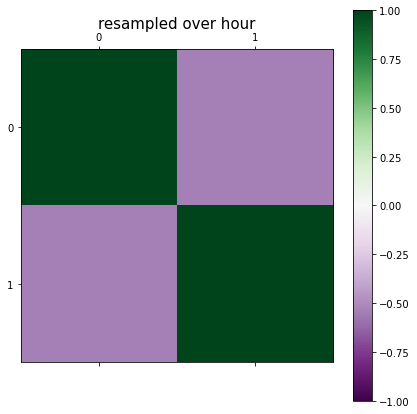

In [4]:
plt.matshow(Zabbix_Data.resample('h').sum().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over hour', size=15)
plt.colorbar()
plt.show()

In [5]:
for j in range(2):
       print(Zabbix_Data.iloc[:, j].unique())

[1601481645 1601481825 1601482005 ... 1604159506 1604159685 1604159865]
[34.8176 34.4525 35.1097 ... 29.1743 29.1521 28.975 ]


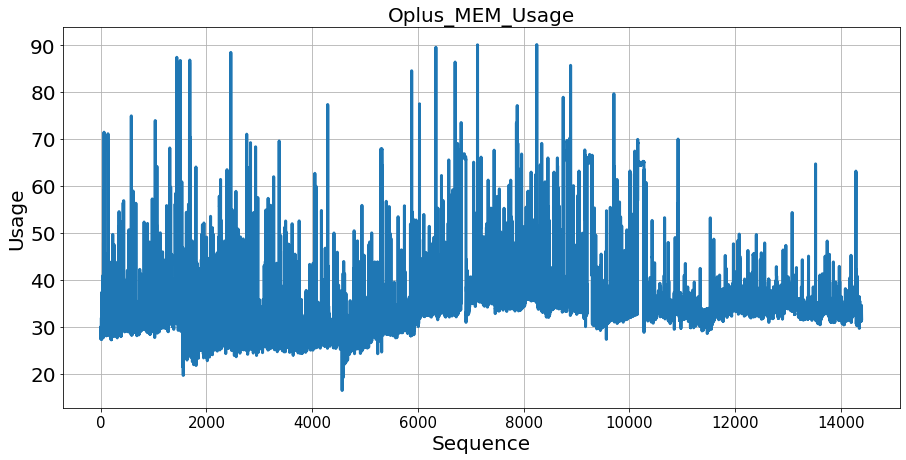

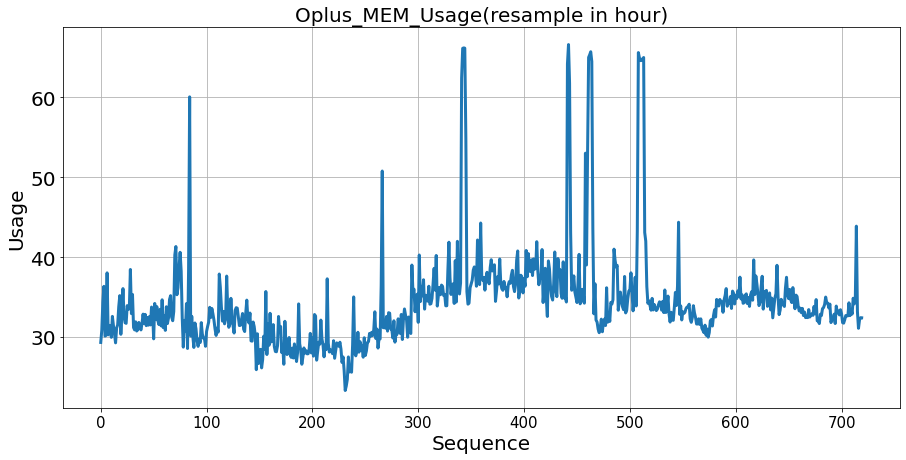

In [6]:
plt.plot(test_Zabbix_Data['%used'].values,linewidth=3)
plt.title('Oplus_MEM_Usage',fontsize=20)
plt.ylabel('Usage',fontsize=20)
plt.xlabel('Sequence',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.grid()
#plt.legend(fontsize='xx-large')
plt.show()

values = test_Zabbix_Data['%used'].resample('H').mean().values
plt.plot(values,linewidth=3)
plt.title('Oplus_MEM_Usage(resample in hour)',fontsize=20)
plt.ylabel('Usage',fontsize=20)
plt.xlabel('Sequence',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.grid()
#plt.legend(fontsize='xx-large')
plt.show()




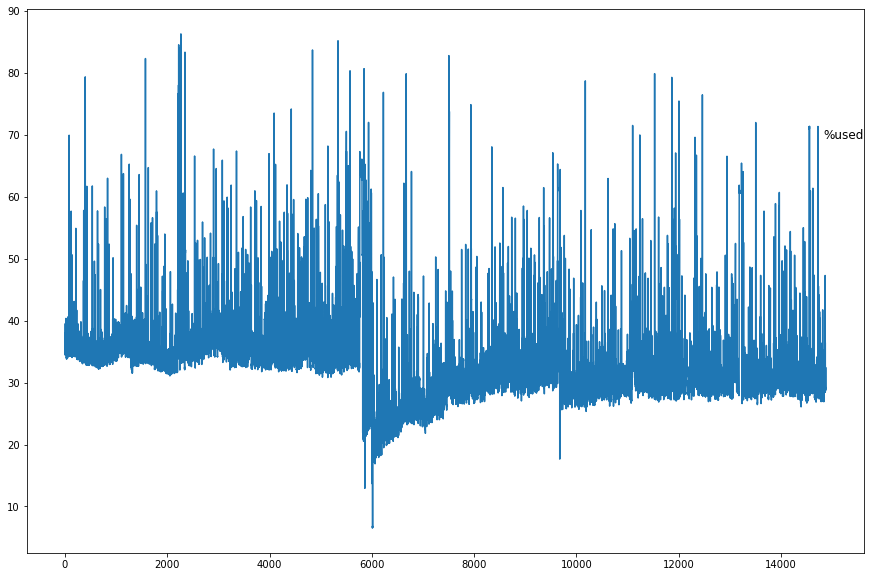

In [7]:
# Below I compare the mean of different features resampled over day. 
# specify columns to plot
df = Zabbix_Data
cols = [1]
i = 1
groups=cols
values = df.values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

# Resample and Training

No handles with labels found to put in legend.


(14878, 1)
(14398, 1)


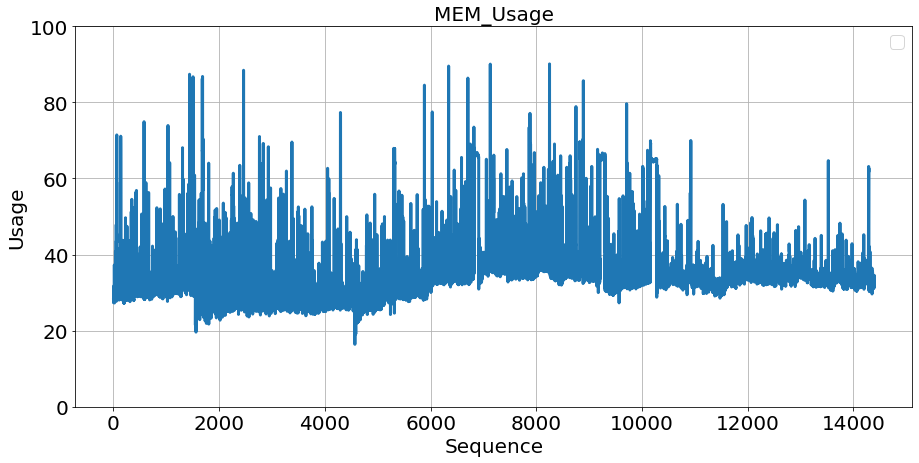

No handles with labels found to put in legend.


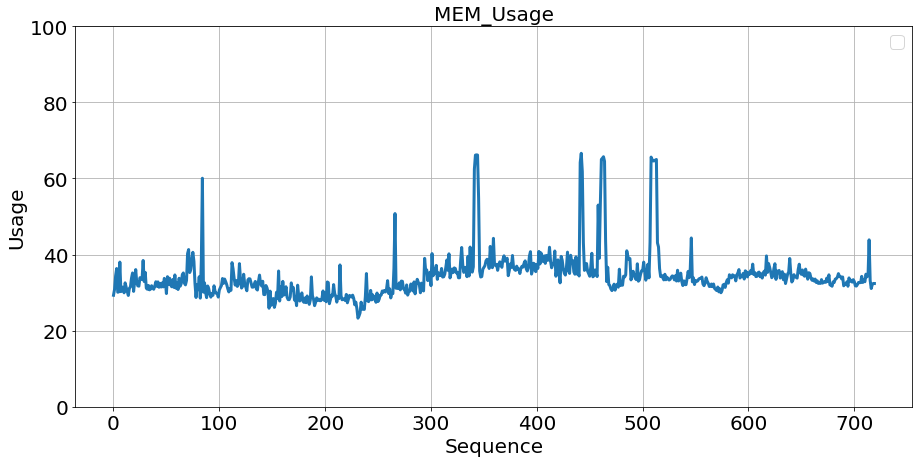

In [8]:
resample_data_freq = 'H'
#Usage_data = Zabbix_Data['%used'].resample(resample_data_freq).mean()
#test_Usage_data = test_Zabbix_Data['%used'].resample(resample_data_freq).mean()

Usage_data = Zabbix_Data['%used']
test_Usage_data = test_Zabbix_Data['%used']




Data_arr = Usage_data.values.reshape(-1,1)
test_Data_arr = test_Usage_data.values.reshape(-1,1)
print(Data_arr.shape)
print(test_Data_arr.shape)

plt.plot(test_Zabbix_Data['%used'].values,linewidth=3)
plt.title('MEM_Usage',fontsize=20)
plt.ylabel('Usage',fontsize=20)
plt.xlabel('Sequence',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim((0,100))
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

values = test_Zabbix_Data['%used'].resample(resample_data_freq).mean().values
plt.plot(values,linewidth=3)
plt.title('MEM_Usage',fontsize=20)
plt.ylabel('Usage',fontsize=20)
plt.xlabel('Sequence',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim((0,100))
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

# Train Test Split

In [9]:
#training_count = int(Data_arr.shape[0]*0.8)

#training_set = Data_arr[:training_count,:]
#testing_set = Data_arr[training_count:]

In [10]:
training_set = Data_arr[:,:]
testing_set  = test_Data_arr[:,:]

# Scale

In [11]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler,RobustScaler


#MinMaxScaler


#sc_train = MinMaxScaler(feature_range=(0,1))
#dataset_train_scaled = sc_train.fit_transform(training_set)

#sc_test = MinMaxScaler(feature_range=(0,1))
#dataset_test_scaled = sc_test.fit_transform(testing_set)


#RobustScaler

sc_train = RobustScaler()
dataset_train_scaled = sc_train.fit_transform(training_set)


sc_test = RobustScaler()
dataset_test_scaled = sc_test.fit_transform(testing_set)


# Dataset generator

In [12]:
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, :])
        y_train.append(data[i:i+y_window_size, 0:1 ])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))
    y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[1]))
    
    return X_train,y_train

#SIZE/hour
INPUT_SIZE = 1
FORCASTING_SIZE =  1   
    
X_train,y_train = gen_dataset(dataset_train_scaled,INPUT_SIZE,FORCASTING_SIZE)
X_test,y_test = gen_dataset(dataset_test_scaled,INPUT_SIZE,FORCASTING_SIZE)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14876, 1, 1)
(14876, 1)
(14396, 1, 1)
(14396, 1)


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

rp = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.01, 
    patience=5, 
    verbose=1, 
    mode='auto', 
    min_delta=0.01, 
    cooldown=0, 
    min_lr=0
)
filepath=r".\model\NXP_model\NXP_best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
mode='max')


# save TF mdoel

In [139]:
tf.saved_model.save(MODEL, "./DLT_model/D_B_LSTM")

INFO:tensorflow:Assets written to: ./DLT_model/D_B_LSTM\assets


INFO:tensorflow:Assets written to: ./DLT_model/D_B_LSTM\assets


In [124]:
tf.keras.models.save_model(D_B_LSTM,r"E:\Server_mantain\Spark_test\DLT_model\D_B_LSTM.h5")

In [ ]:
tf

# Model

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_162 (Bidirecti (None, 60, 128)           25728     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
bidirectional_163 (Bidirecti (None, 60, 128)           74496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
bidirectional_164 (Bidirecti (None, 128)               74496     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)               

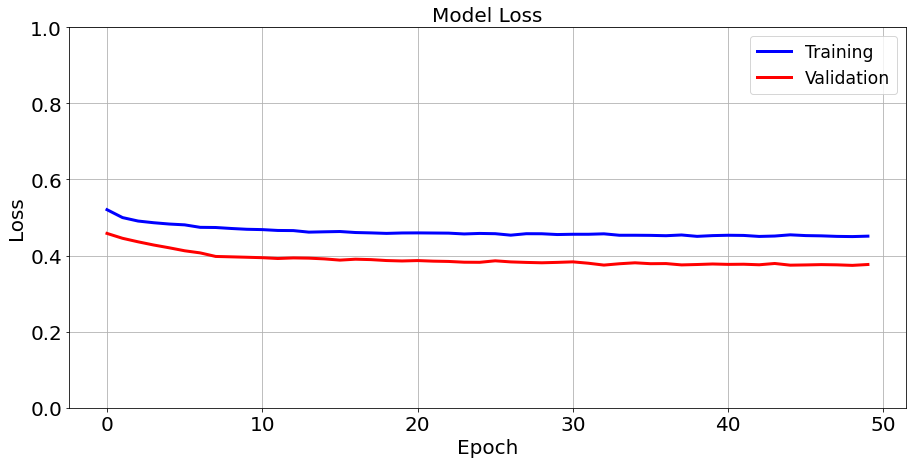

In [80]:

from attention import Attention
from tensorflow.keras.layers import Bidirectional
 #= tf.keras.initializers.Orthogonal(gain=1.0, seed=None)

    
One_LSTM = Sequential()
One_LSTM.add(LSTM(64, return_sequences=False,unroll=False),input_shape=(X_train.shape[1],X_train.shape[2]))
One_LSTM.add(Dense(y_test.shape[1]))

One_B_LSTM = Sequential()
One_B_LSTM.add(Bidirectional(LSTM(64, return_sequences=False,unroll=False),input_shape=(X_train.shape[1],X_train.shape[2])))
One_B_LSTM.add(Dense(y_test.shape[1]))

D_LSTM = Sequential()
D_LSTM.add(LSTM(64, return_sequences=True,unroll=False),input_shape=(X_train.shape[1],X_train.shape[2]))
D_LSTM.add(LSTM(64, return_sequences=True,unroll=False),input_shape=(X_train.shape[1],X_train.shape[2]))
D_LSTM.add(LSTM(64, return_sequences=False,unroll=False),input_shape=(X_train.shape[1],X_train.shape[2]))
D_LSTM.add(Dense(y_test.shape[1]))

D_B_LSTM = Sequential()
D_B_LSTM.add(Bidirectional(LSTM(64, return_sequences=True,unroll=False),input_shape=(X_train.shape[1],X_train.shape[2])))
D_B_LSTM.add(Bidirectional(LSTM(64, return_sequences=True,unroll=False)))
D_B_LSTM.add(Bidirectional(LSTM(64, return_sequences=False,unroll=False)))
D_B_LSTM.add(Dense(y_test.shape[1]))







#model.add(Activation('linear'))
optz_fun = Adam(learning_rate=0.0001)

model.compile(loss='mae',optimizer=optz_fun)
model.summary()
EPOCH = 50
BATCH = 32
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,validation_split=0.2,callbacks=[],shuffle=False,verbose=1)

plt.plot( history.history['loss'], 'b', label='Training',linewidth=3)
plt.plot( history.history['val_loss'], 'r', label='Validation',linewidth=3)
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,1)
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()






In [ ]:
model = tf.keras.models.load_model(r'E:\Server_mantain\Spark_test\Model\best_model\Zabbix_model_GRU64-0')

23/23 [==============================] - 0s 4ms/step - loss: 0.4836
score :  0.48364725708961487


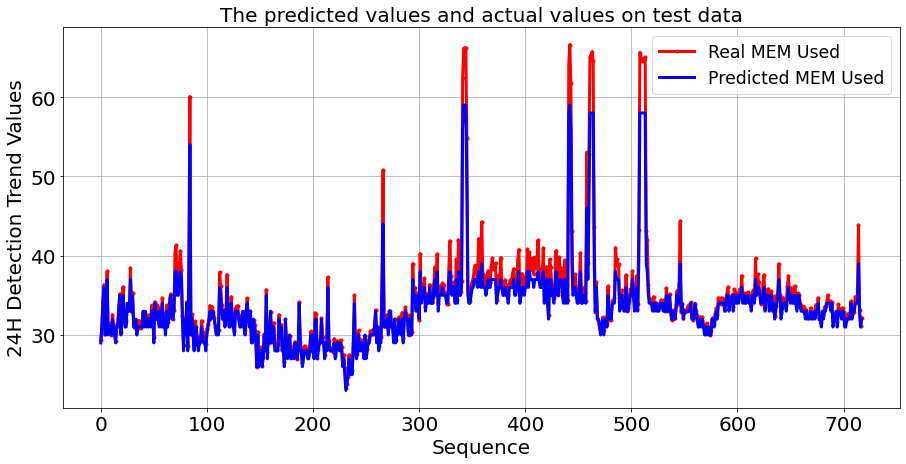

Result:
Test Score: 0.86 MAE
Test Score: 1.56 RMSE
Test Score: 13.61 MAPE
Test Score: 93.45 R2Score


In [132]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from  datetime import datetime



def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score= model.evaluate(X_test,y_test)
print("score : ",score)
predicted_traffic = model.predict(X_test)
predicted_traffic = sc_test.inverse_transform(predicted_traffic) 

predicted_traffic = predicted_traffic.astype('int64')
predicted_traffic = predicted_traffic.flatten()

from sklearn.metrics import r2_score
bound = 2
MAEScore = mean_absolute_error(testing_set[:-bound],predicted_traffic)
RMSEScore = math.sqrt(mean_squared_error(testing_set[:-bound],predicted_traffic))
MAPEScore = mean_absolute_percentage_error(testing_set[:-bound],predicted_traffic[:])
R2Score = r2_score(testing_set[:-bound],predicted_traffic)

plt.plot(testing_set[:-bound],color = 'red',marker='.', label = 'Real MEM Used',linewidth=3)
plt.plot(predicted_traffic[:],color = 'blue', label = 'Predicted MEM Used',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
#plt.ylim(0)
plt.legend(fontsize='xx-large')
plt.xlabel('Sequence',fontsize=20)
plt.ylabel('24H Detection Trend Values',fontsize=20)
plt.title('The predicted values and actual values on test data',fontsize=20)
plt.show()



now_time = datetime.now()     #獲取當前時間
now_time = now_time.strftime('%Y%m%d_%H%M%S')   #列印需要的資訊,依次是年月日,時分秒,注意字母大小寫
print ("Result:")


print('Test Score: %.2f MAE' % (MAEScore))
print('Test Score: %.2f RMSE' % (RMSEScore))
print('Test Score: %.2f MAPE' % (MAPEScore))
print('Test Score: %.2f R2Score' % (R2Score*100))

# Find 90 score model

In [86]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error,r2_score
from  datetime import datetime


R2score_list = []
for i in range(50):
    #del model
    print("Start {}th training".format(i+1))
    
    model = Sequential()
    model.add(Bidirectional(GRU(64, return_sequences=True,unroll=False),input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Bidirectional(GRU(64, return_sequences=True,unroll=False)))
    model.add(Bidirectional(GRU(64, return_sequences=False,unroll=False)))

    model.add(Dense(y_test.shape[1]))
    #model.add(Activation('linear'))
    optz_fun = Adam(learning_rate=0.001)

    model.compile(loss='mae',optimizer=optz_fun)
    #model.summary()
    EPOCH = 50
    BATCH = 30
    history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,validation_split=0.2,callbacks=[],shuffle=False,verbose=0)
    
    predicted_traffic = model.predict(X_test)
    predicted_traffic = sc_test.inverse_transform(predicted_traffic) 

    predicted_traffic = predicted_traffic.astype('int64')
    predicted_traffic = predicted_traffic.flatten()

    from sklearn.metrics import r2_score
    
    bound = 61

    MAEScore = mean_absolute_error(testing_set[bound:,:],predicted_traffic)
    RMSEScore = math.sqrt(mean_squared_error(testing_set[bound:,:],predicted_traffic))
    R2Score = r2_score(testing_set[bound:,:],predicted_traffic)*100
    print("-{} : {}".format(i,R2Score))
    R2score_list.append(R2Score)
    if R2Score >= 90:
        tf.saved_model.save(model, "./Model/Zabbix_model_GRU64_60put-{}".format(i))
        
        


#plot best model        
plt.plot(R2score_list,marker='.',color='blue', label = 'Real MEM Used',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize='xx-large')
plt.xlabel('chance',fontsize=20)
plt.ylabel('R2score',fontsize=20)
plt.title('Model Performance  best-[{} : {}]'.format(R2score_list.index(max(R2score_list)),max(R2score_list)),fontsize=20)
plt.show()

Start 1th training
-0 : 42.167374671889135
Start 2th training
-1 : 43.507865609410224
Start 3th training
-2 : 44.124112865037176
Start 4th training
-3 : 42.13990935557913
Start 5th training
-4 : 46.56525389421125
Start 6th training
-5 : 46.648016316242405
Start 7th training
-6 : 44.11317340903892
Start 8th training
-7 : 41.93262559190315
Start 9th training
-8 : 43.64566746976609
Start 10th training
-9 : 45.170602883259136
Start 11th training
-10 : 44.4518989812471
Start 12th training
-11 : 41.538407911841325
Start 13th training
-12 : 45.49697464054372
Start 14th training
-13 : 43.39122630881328
Start 15th training
-14 : 43.90480714268461
Start 16th training
-15 : 43.77307056080711
Start 17th training
-16 : 42.191829566434926
Start 18th training
-17 : 45.98875363216573
Start 19th training
-18 : 44.67206420183004
Start 20th training
-19 : 45.48300291406105
Start 21th training
-20 : 44.50665132093516
Start 22th training
-21 : 46.334627907417534
Start 23th training
-22 : 45.21636044132975


KeyboardInterrupt: 

In [60]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from  datetime import datetime

model = tf.keras.models.load_model('./Model/Zabbix_model-1')

score= model.evaluate(X_test,y_test)
print("score : ",score)
predicted_traffic = model.predict(X_test)
predicted_traffic = sc_test.inverse_transform(predicted_traffic) 

predicted_traffic = predicted_traffic.astype('int64')
predicted_traffic = predicted_traffic.flatten()

from sklearn.metrics import r2_score

MAEScore = mean_absolute_error(testing_set[:-2,:],predicted_traffic)
RMSEScore = math.sqrt(mean_squared_error(testing_set[:-2,:],predicted_traffic))
R2Score = r2_score(testing_set[:-2,:],predicted_traffic)

plt.plot(testing_set[:],color = 'red',marker='.', label = 'Real MEM Used',linewidth=3)
plt.plot(predicted_traffic[:],color = 'blue', label = 'Predicted MEM Used',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
#plt.ylim(0)
plt.legend(fontsize='xx-large')
plt.xlabel('Sequence',fontsize=20)
plt.ylabel('24H Detection Trend Values',fontsize=20)
plt.title('The predicted values and actual values on test data : %.2f MAE, %.2f RMSE\n%s'%(MAEScore,RMSEScore,resample_data_freq),fontsize=20)
plt.show()



now_time = datetime.now()     #獲取當前時間
now_time = now_time.strftime('%Y%m%d_%H%M%S')   #列印需要的資訊,依次是年月日,時分秒,注意字母大小寫
print ("Result:")


print('Test Score: %.2f MAE' % (MAEScore))
print('Test Score: %.2f RMSE' % (RMSEScore))
print('Test Score: %.2f R2Score' % (R2Score*100))

OSError: SavedModel file does not exist at: ./Model/Zabbix_model-1/{saved_model.pbtxt|saved_model.pb}

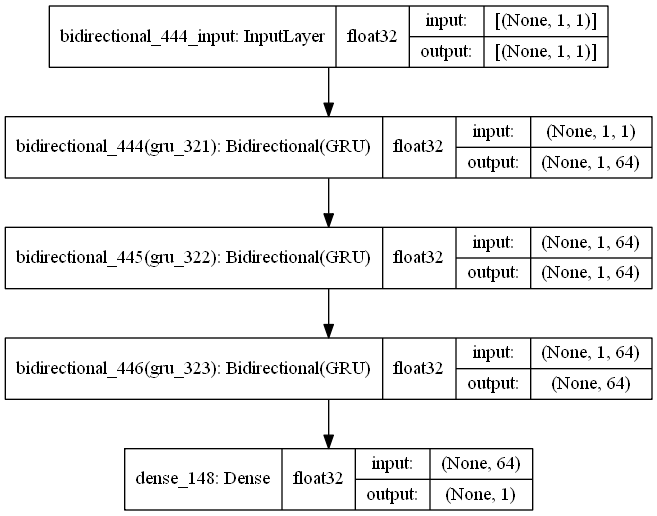

In [62]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [26]:
model = tf.keras.models.load_model(r'E:\Server_mantain\Spark_test\DLT_model\One_B_LSTM.h5')
#tf.saved_model.save(model,r"E:\Server_mantain\Spark_test\DLT_model\One_LSTM")

In [27]:
model = tf.keras.models.load_model(r'E:\Server_mantain\Spark_test\DLT_model\One_B_LSTM.h5')
for i in model.layers:
    print(i.name)

bidirectional_289
dense_101
